In [1]:
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy as sp
import pandas as pd

from sklearn import preprocessing

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFECV

from matplotlib import pyplot

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score

from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

import warnings
#warnings.filterwarnings("ignore")

In [2]:
#Returns null values (%)
def get_nans(df):
    nan_dic = {}
    for col in df.columns:
        if df[col].isnull().any() == True:
            nan_dic[col] = df[col].isnull().sum()
    return pd.DataFrame({
        'Feature': list(nan_dic.keys()),
        'Nulls': list(nan_dic.values()),
        'Percent': np.round((np.array(list(nan_dic.values())) / df.shape[0])*100, decimals = 1)
    }).sort_values('Nulls',ascending = False)

#Returns 0 values (%)

def get_zeros(df):
    zero_dic = {}
    for col in df.columns:
        if (df[col] == 0).sum() > 0:
            zero_dic[col] = (df[col] == 0).sum()
    return pd.DataFrame({'Feature': list(zero_dic.keys()),
                        'Zeros': list(zero_dic.values()),
                        'Percent': np.round((np.array(list(zero_dic.values())) / df.shape[0])*100, decimals = 1)
    }).sort_values('Zeros',ascending = False)

In [3]:
train_data =pd.read_csv('train.csv', delimiter=',')
test_data  =pd.read_csv('test.csv', delimiter=',')


In [4]:
test_data  = test_data.loc[:, (test_data  != 0).any(axis=0)]
# Create an column representing the target and assign negative value in order to facilitate the split
test_data['NU_NOTA_MT'] = -148
train_data = train_data.loc[:, test_data.columns]

My ideia was to concat the two data sets in order to make easy apply the preprocessing techniques

In [5]:
frames = [test_data,train_data]
df = pd.concat(frames)

df.head()

,NU_INSCRICAO,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,41,PR,22,F,3,1,1,5,1,...,420.0,B,A,C,A,A,C,C,A,-148.0
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,21,MA,26,F,3,1,1,8,1,...,580.0,E,B,C,B,B,B,F,A,-148.0
2,b38a03232f43b11c9d0788abaf060f7366053b6d,23,CE,21,M,1,1,2,0,2,...,320.0,E,E,D,B,B,A,NaN,A,-148.0
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,15,PA,27,F,3,1,1,8,1,...,NaN,H,E,G,B,B,A,NaN,A,-148.0
4,715494628a50142ce8cb17191cfe6d0f3cae0934,41,PR,18,M,1,1,2,0,2,...,320.0,D,H,H,C,B,A,NaN,A,-148.0


In [6]:
#CO_UF_RESIDENCIA and SG_UF_RESIDENCIA represent the same information, the state's code, so we drop one of them
df.drop(['SG_UF_RESIDENCIA'], axis = 1, inplace = True)

#Define NaN values in target as 0

for i in ['NU_NOTA_MT']:
    df[i].fillna(0,inplace=True)

In [7]:
#Set categorical features as "category" dtype and get cat codes, before assigning the mode of columns to NaN values

for i in ['CO_PROVA_CN','CO_PROVA_MT', 'CO_PROVA_LC', 'CO_PROVA_CH', 'Q001', 'Q002','Q006','Q024','Q025','Q026','Q027','Q047','TP_SEXO']:
    df[i] = df[i].fillna(df[i].mode()[0])
    df[i] = df[i].astype('category')
    df[i] = df[i].cat.codes

#The remaining columns we replace NaN by median
df.fillna(df.median(), inplace=True)

In [8]:
df.head()

,NU_INSCRICAO,CO_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,...,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,41,22,0,3,1,1,5,1,1.0,...,420.0,1,0,2,0,0,2,2,0,-148.0
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,21,26,0,3,1,1,8,1,1.0,...,580.0,4,1,2,1,1,1,5,0,-148.0
2,b38a03232f43b11c9d0788abaf060f7366053b6d,23,21,1,1,1,2,0,2,3.0,...,320.0,4,4,3,1,1,0,5,0,-148.0
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,15,27,0,3,1,1,8,1,1.0,...,540.0,7,4,6,1,1,0,5,0,-148.0
4,715494628a50142ce8cb17191cfe6d0f3cae0934,41,18,1,1,1,2,0,2,1.0,...,320.0,3,7,7,2,1,0,5,0,-148.0


In [9]:
# Separate de the features we want do apply dummy

cat = set(df.columns)-set(['NU_INSCRICAO', 'NU_NOTA_COMP5', 'NU_NOTA_COMP3','NU_NOTA_COMP4','NU_NOTA_COMP1','NU_NOTA_REDACAO', 'Q001', 'Q002','Q006','Q024','Q025','Q026','Q027','Q047','NU_NOTA_COMP2','NU_NOTA_MT','NU_NOTA_LC','NU_NOTA_CN','NU_NOTA_CH'])
df = pd.get_dummies(df, columns=cat, drop_first=True)
df.shape


(18306, 184)

In [10]:
# Split out data set by the value we put in test data, -148

train = df.loc[df['NU_NOTA_MT'] != -148]
test =  df.loc[df['NU_NOTA_MT'] == -148]
print(train.shape, test.shape)

(13730, 184) (4576, 184)


In [11]:
#Apply standard scaler to (original)

train = train.drop(['NU_INSCRICAO'], axis=1)
y = train['NU_NOTA_MT'].copy()
X = train.drop(['NU_NOTA_MT'], axis=1)

names = X.columns
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(X)
X = pd.DataFrame(scaled_df, columns=names)

#Apply standard scaler to test (the one provided)

test_1= test.drop(['NU_INSCRICAO'], axis=1)
X_test = test_1.drop(['NU_NOTA_MT'], axis=1)
scaled_df_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(scaled_df_test, columns=names)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
print('test',X_train.shape, y_train.shape)
print('train',X_val.shape, y_val.shape)

test (9611, 182) (9611,)
train (4119, 182) (4119,)


In [13]:


#Feature ranking with recursive feature elimination and cross-validated selection of the best number of features.

clf1 = XGBRegressor()
rfecv = RFECV(estimator=clf1, step=1, cv=5,scoring='neg_mean_squared_error', n_jobs=4,verbose=1)
rfecv = rfecv.fit(X_train,y_train)

print('Numero otimo de Features : ', rfecv.n_features_)


Fitting estimator with 182 features.
Fitting estimator with 181 features.
Fitting estimator with 180 features.
Fitting estimator with 179 features.
Fitting estimator with 178 features.
Fitting estimator with 177 features.
Fitting estimator with 176 features.
Fitting estimator with 175 features.
Fitting estimator with 174 features.
Fitting estimator with 173 features.
Fitting estimator with 172 features.
Fitting estimator with 171 features.
Fitting estimator with 170 features.
Fitting estimator with 169 features.
Fitting estimator with 168 features.
Fitting estimator with 167 features.
Fitting estimator with 166 features.
Fitting estimator with 165 features.
Fitting estimator with 164 features.
Fitting estimator with 163 features.
Fitting estimator with 162 features.
Fitting estimator with 161 features.
Fitting estimator with 160 features.
Fitting estimator with 159 features.
Fitting estimator with 158 features.
Fitting estimator with 157 features.
Fitting estimator with 156 features.
F

The optimal number of features is 39
The selected features are:
['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'Q002', 'Q006', 'Q024', 'Q026', 'Q027', 'Q047', 'TP_COR_RACA_1', 'TP_COR_RACA_4', 'TP_ANO_CONCLUIU_1', 'TP_ANO_CONCLUIU_7', 'TP_ENSINO_3.0', 'NU_IDADE_26', 'NU_IDADE_30', 'NU_IDADE_45', 'NU_IDADE_58', 'CO_PROVA_CN_2', 'CO_PROVA_CN_3', 'CO_PROVA_CN_5', 'TP_PRESENCA_LC_1', 'TP_DEPENDENCIA_ADM_ESC_2.0', 'TP_SEXO_1', 'CO_PROVA_LC_1', 'CO_PROVA_LC_6', 'CO_PROVA_LC_7', 'CO_UF_RESIDENCIA_15', 'CO_UF_RESIDENCIA_16', 'CO_UF_RESIDENCIA_21', 'CO_UF_RESIDENCIA_22', 'CO_UF_RESIDENCIA_25', 'CO_UF_RESIDENCIA_31', 'CO_UF_RESIDENCIA_32', 'CO_UF_RESIDENCIA_41', 'CO_UF_RESIDENCIA_53', 'IN_SABATISTA_1', 'CO_PROVA_MT_7']
Out of sample auc: 0.9226998259779099


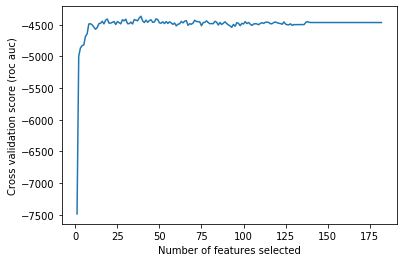

In [14]:
print('The optimal number of features is {}'.format(rfecv.n_features_))
features = [f for f,s in zip(X_train.columns, rfecv.support_) if s]
print('The selected features are:')
print ('{}'.format(features))

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (roc auc)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.savefig('feature_auc_nselected.png', bbox_inches='tight', pad_inches=1)

X_train_s = X_train[features]

clf1.fit(X_train_s, y_train)

X_val_s = X_val[features]
print ('Out of sample auc: {}'.format(clf1.score(X_val_s, y_val)))


In [15]:
def Grid_Search_CV_RFR(X_train, y_train):
    estimator = RandomForestRegressor()
    param_grid = { 
            "max_depth"         : [ 5, 10, 15, 20, 30],
            "n_estimators"      : [8, 16, 32, 64, 100],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [4,8,12],
            "bootstrap": [True, False],
            }

    grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5, verbose = 3)

    grid.fit(X_train, y_train)

    return grid.best_score_ , grid.best_params_

def RFR(X_train, X_test, y_train, y_test, best_params):

    estimator = RandomForestRegressor(n_jobs=-1).set_params(**best_params)
    estimator.fit(X_train,y_train)

    y_predict = estimator.predict(X_test)
    return y_test,y_predict

def splitter_v2(tab,y_indicator):

    # Asignamos X e y, eliminando la columna y en X
    X = correlacion(tab,y_indicator)
    y = tab[:,y_indicator]
    # Separamos Train y Test respectivamente para X e y
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    return X_train, X_test, y_train, y_test

In [16]:
print ("Loop: all features" )
print ("--------------")

best_score, best_params = Grid_Search_CV_RFR(X_train, y_train)
y_val , y_pred = RFR(X_train, X_val, y_train, y_val, best_params)
print("Best Score:" ,best_score)
print("Best params:",best_params)
print('Explained Variance Score', explained_variance_score(y_val, y_pred)) 
#The best possible score is 1.0, lower values are worse.
print('Max Error:', (max_error(y_val, y_pred)))
# maior real - predito
print('Mean Absolute Error:', mean_absolute_error(y_val, y_pred))
# MAE = (real - predito) / n, erro médio
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_val, y_pred)))
# RMSE = raiz do quadrado do anterior
print('Median Squared Error:', median_absolute_error(y_val, y_pred))
# mediana dos (real - predito)
print('R² score:', r2_score(y_val, y_pred))


Loop: all features
--------------
Fitting 5 folds for each of 450 candidates, totalling 2250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed: 22.6min finished


Best Score: 0.9232962851064107
Best params: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 8, 'n_estimators': 100}
Explained Variance Score 0.929438901044644
Max Error: 442.5657146794794
Mean Absolute Error: 41.628014112017134
Root Mean Squared Error: 61.5996840746597
Median Squared Error: 30.485450434613426
R² score: 0.9294373450807969


In [17]:
print ("Loop: selected features" )
print ("--------------")

best_score, best_params = Grid_Search_CV_RFR(X_train_s, y_train)
y_val , y_pred = RFR(X_train_s, X_val_s, y_train, y_val, best_params)
print("Best Score:" ,best_score)
print("Best params:",best_params)
print('Explained Variance Score', explained_variance_score(y_val, y_pred)) 
#The best possible score is 1.0, lower values are worse.
print('Max Error:', (max_error(y_val, y_pred)))
# maior real - predito
print('Mean Absolute Error:', mean_absolute_error(y_val, y_pred))
# MAE = (real - predito) / n, erro médio
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_val, y_pred)))
# RMSE = raiz do quadrado do anterior
print('Median Squared Error:', median_absolute_error(y_val, y_pred))
# mediana dos (real - predito)
print('R² score:', r2_score(y_val, y_pred))

Loop: selected features
--------------
Fitting 5 folds for each of 450 candidates, totalling 2250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed:  8.2min finished


Best Score: 0.9230413409903271
Best params: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 12, 'n_estimators': 100}
Explained Variance Score 0.9293524367038593
Max Error: 446.4224223962906
Mean Absolute Error: 41.65859480902688
Root Mean Squared Error: 61.63746670332073
Median Squared Error: 29.747938373990053
R² score: 0.9293507582663731


In [18]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.5,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

y_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)

print('Explained Variance Score', explained_variance_score(y_val, y_pred)) 
#The best possible score is 1.0, lower values are worse.
print('Max Error:', (max_error(y_val, y_pred)))
# maior real - predito
print('Mean Absolute Error:', mean_absolute_error(y_val, y_pred))
# MAE = (real - predito) / n, erro médio
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_val, y_pred)))
# RMSE = raiz do quadrado do anterior
print('Median Squared Error:', median_absolute_error(y_val, y_pred))
# mediana dos (real - predito)
print('R² score:', r2_score(y_val, y_pred))

[1]	valid_0's l2: 16550.9	valid_0's l1: 105.81
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 7150.84	valid_0's l1: 70.4028
[3]	valid_0's l2: 4773.54	valid_0's l1: 55.2389
[4]	valid_0's l2: 4189.13	valid_0's l1: 48.3655
[5]	valid_0's l2: 4036.99	valid_0's l1: 45.1687
[6]	valid_0's l2: 4037.42	valid_0's l1: 43.8172
[7]	valid_0's l2: 4045.8	valid_0's l1: 43.1571
[8]	valid_0's l2: 4068.82	valid_0's l1: 43.2485
[9]	valid_0's l2: 4086.57	valid_0's l1: 43.1531
[10]	valid_0's l2: 4112.97	valid_0's l1: 43.2738
Early stopping, best iteration is:
[5]	valid_0's l2: 4036.99	valid_0's l1: 45.1687
Explained Variance Score 0.9249283771746605
Max Error: 489.23556790573633
Mean Absolute Error: 45.16866567992274
Root Mean Squared Error: 63.53732595415729
Median Squared Error: 29.066285506710074
R² score: 0.9249283762866263


In [19]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.5,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

lgb_train = lgb.Dataset(X_train_s, y_train)
lgb_eval = lgb.Dataset(X_val_s, y_val, reference=lgb_train)

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

y_pred = gbm.predict(X_val_s, num_iteration=gbm.best_iteration)

print('Explained Variance Score', explained_variance_score(y_val, y_pred)) 
#The best possible score is 1.0, lower values are worse.
print('Max Error:', (max_error(y_val, y_pred)))
# maior real - predito
print('Mean Absolute Error:', mean_absolute_error(y_val, y_pred))
# MAE = (real - predito) / n, erro médio
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_val, y_pred)))
# RMSE = raiz do quadrado do anterior
print('Median Squared Error:', median_absolute_error(y_val, y_pred))
# mediana dos (real - predito)
print('R² score:', r2_score(y_val, y_pred))

[1]	valid_0's l2: 16546.2	valid_0's l1: 105.798
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 7160.38	valid_0's l1: 70.4873
[3]	valid_0's l2: 4788.88	valid_0's l1: 55.2405
[4]	valid_0's l2: 4193.83	valid_0's l1: 48.5626
[5]	valid_0's l2: 4042.96	valid_0's l1: 45.3648
[6]	valid_0's l2: 4020.26	valid_0's l1: 43.8485
[7]	valid_0's l2: 4068.93	valid_0's l1: 43.3633
[8]	valid_0's l2: 4081.44	valid_0's l1: 43.0652
[9]	valid_0's l2: 4100.59	valid_0's l1: 43.21
[10]	valid_0's l2: 4124.53	valid_0's l1: 43.3205
[11]	valid_0's l2: 4113.31	valid_0's l1: 43.1398
Early stopping, best iteration is:
[6]	valid_0's l2: 4020.26	valid_0's l1: 43.8485
Explained Variance Score 0.9252397183675909
Max Error: 466.01389665669683
Mean Absolute Error: 43.848499415955324
Root Mean Squared Error: 63.40555799036314
Median Squared Error: 29.417939605689526
R² score: 0.9252394305359057


In [22]:
from sklearn import model_selection 

model = XGBRegressor(max_depth = 5,
                   learning_rate = 0.05,
                   n_estimators = 500,
                   n_jobs = 5,
                   subsample= 0.25,
                   min_child_weight=1,
                     objective = 'reg:linear',
                   colsample_bytree=1
                   
                  )
splits = 5
folds = model_selection.KFold(n_splits=splits)


model.fit(X_train, y_train)
y_pred = model.predict(X_val)

print('Explained Variance Score', explained_variance_score(y_val, y_pred)) 
#The best possible score is 1.0, lower values are worse.
print('Max Error:', (max_error(y_val, y_pred)))
# maior real - predito
print('Mean Absolute Error:', mean_absolute_error(y_val, y_pred))
# MAE = (real - predito) / n, erro médio
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_val, y_pred)))
# RMSE = raiz do quadrado do anterior
print('Median Squared Error:', median_absolute_error(y_val, y_pred))
# mediana dos (real - predito)
print('R² score:', r2_score(y_val, y_pred))


[01:04:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[01:05:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
Explained Variance Score 0.926442334950738
Max Error: 452.886474609375
Mean Absolute Error: 42.73003743191198
Root Mean Squared Error: 62.89345758388808
Median Squared Error: 29.054174804687477
R² score: 0.9264421740654549


In [23]:
xgb = XGBRegressor(max_depth = 3,
                   learning_rate = 0.05,
                   n_estimators = 100,
                   n_jobs = 5,
                   subsample=0.5213,
                   min_child_weight=1.7817,
                   reg_alpha=0.4640,
                   reg_lambda=0.8571,
                   gamma=0.0468,
                   colsample_bytree=0.4603
                   
                  )
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_val)
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error,median_absolute_error, r2_score

print('Explained Variance Score', explained_variance_score(y_val, y_pred)) 
#The best possible score is 1.0, lower values are worse.
print('Max Error:', (max_error(y_val, y_pred)))
# maior real - predito
print('Mean Absolute Error:', mean_absolute_error(y_val, y_pred))
# MAE = (real - predito) / n, erro médio
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_val, y_pred)))
# RMSE = raiz do quadrado do anterior
print('Median Squared Error:', median_absolute_error(y_val, y_pred))
# mediana dos (real - predito)
print('R² score:', r2_score(y_val, y_pred))

from sklearn.model_selection import RandomizedSearchCV

parameters = {'objective':['reg:linear'],
              'learning_rate': [0.1, 0.2, 0.5, 0.05],
              'max_depth': [2,3,4,5,6,7],
              'min_child_weight': [0.5,1],
              'subsample': [0.25,0.5,1],
              'colsample_bytree': [0.5,1],
              'n_estimators': [50, 100, 200, 300, 500]}

rs = RandomizedSearchCV (estimator= xgb,
                        param_distributions= parameters,
                        scoring = 'neg_mean_squared_error',
                        n_jobs= 5,verbose=1,
                        n_iter = 10)

rs_result = rs.fit(X_train,y_train)
y_pred = rs_result.predict(X_val)
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error,median_absolute_error, r2_score

print('Explained Variance Score', explained_variance_score(y_val, y_pred)) 
#The best possible score is 1.0, lower values are worse.
print('Max Error:', (max_error(y_val, y_pred)))
# maior real - predito
print('Mean Absolute Error:', mean_absolute_error(y_val, y_pred))
# MAE = (real - predito) / n, erro médio
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_val, y_pred)))
# RMSE = raiz do quadrado do anterior
print('Median Squared Error:', median_absolute_error(y_val, y_pred))
# mediana dos (real - predito)
print('R² score:', r2_score(y_val, y_pred))

Explained Variance Score 0.9300667825542721
Max Error: 435.914306640625
Mean Absolute Error: 41.767770460231354
Root Mean Squared Error: 61.3730796108229
Median Squared Error: 28.770889282226562
R² score: 0.9299555426092607


C:\Users\Venicius Ferreira\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:  1.6min finished


[01:06:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
Explained Variance Score 0.930605865931951
Max Error: 448.4122009277344
Mean Absolute Error: 42.14896968985304
Root Mean Squared Error: 61.08844767083316
Median Squared Error: 28.859472656249977
R² score: 0.9306037309985555


In [24]:
xgb = XGBRegressor(max_depth = 3,
                   learning_rate = 0.05,
                   n_estimators = 100,
                   n_jobs = 5,
                   subsample=0.5213,
                   min_child_weight=1.7817,
                   reg_alpha=0.4640,
                   reg_lambda=0.8571,
                   gamma=0.0468,
                   colsample_bytree=0.4603
                   
                  )
xgb.fit(X_train_s,y_train)
y_pred = xgb.predict(X_val_s)
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error,median_absolute_error, r2_score

print('Explained Variance Score', explained_variance_score(y_val, y_pred)) 
#The best possible score is 1.0, lower values are worse.
print('Max Error:', (max_error(y_val, y_pred)))
# maior real - predito
print('Mean Absolute Error:', mean_absolute_error(y_val, y_pred))
# MAE = (real - predito) / n, erro médio
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_val, y_pred)))
# RMSE = raiz do quadrado do anterior
print('Median Squared Error:', median_absolute_error(y_val, y_pred))
# mediana dos (real - predito)
print('R² score:', r2_score(y_val, y_pred))

from sklearn.model_selection import RandomizedSearchCV

parameters = {'objective':['reg:linear'],
              'learning_rate': [0.1, 0.2, 0.5, 0.05],
              'max_depth': [2,3,4,5,6,7],
              'min_child_weight': [0.5,1],
              'subsample': [0.25,0.5,1],
              'colsample_bytree': [0.5,1],
              'n_estimators': [50, 100, 200, 300, 500]}

rs = RandomizedSearchCV (estimator= xgb,
                        param_distributions= parameters,
                        scoring = 'neg_mean_squared_error',
                        n_jobs= 5,verbose=1,
                        n_iter = 10)

rs_result = rs.fit(X_train_s,y_train)
y_pred = rs_result.predict(X_val_s)
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error,median_absolute_error, r2_score

print('Explained Variance Score', explained_variance_score(y_val, y_pred)) 
#The best possible score is 1.0, lower values are worse.
print('Max Error:', (max_error(y_val, y_pred)))
# maior real - predito
print('Mean Absolute Error:', mean_absolute_error(y_val, y_pred))
# MAE = (real - predito) / n, erro médio
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_val, y_pred)))
# RMSE = raiz do quadrado do anterior
print('Median Squared Error:', median_absolute_error(y_val, y_pred))
# mediana dos (real - predito)
print('R² score:', r2_score(y_val, y_pred))

Explained Variance Score 0.9281822238193368
Max Error: 444.0349426269531
Mean Absolute Error: 42.61930843139627
Root Mean Squared Error: 62.19299801479192
Median Squared Error: 31.63154296875001
R² score: 0.9280715125008849
Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Venicius Ferreira\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:   32.8s finished


[01:07:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
[01:07:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.1.0/src/objective/regression_obj.cu:168: reg:linear is now deprecated in favor of reg:squarederror.
Explained Variance Score 0.9288949395072128
Max Error: 441.46221923828125
Mean Absolute Error: 42.03463753442591
Root Mean Squared Error: 61.83607169736092
Median Squared Error: 29.063861083984364
R² score: 0.9288947402490864
